<a href="https://colab.research.google.com/github/ruddysimon/Predictive-Insurance-Premium-Estimation-with-XGBoost/blob/main/Insurance_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Approach**
- Investigating the Data through Exploratory Data Analysis (EDA)
- Creating and Assessing a Baseline Linear Model
- Examining Linear Regression Assumptions
- Preprocessing the Data for Modeling
- Training the Model
- Evaluating the Model's Performance
- Enhancing the Baseline Linear Model
- Introducing a Non-Linear Model: XGBoost
- Data Preprocessing for XGBoost
- Optimizing Model Training with Sklearn's Pipeline
- Evaluating the Performance of the XGBoost Model
- Comparing the XGBoost Model to the Baseline Linear Model

**Install Packages**

In [3]:
!pip install numpy==1.21.0 --quiet
!pip install pandas==1.5.2 --quiet
!pip install plotly==5.11.0 --quiet
!pip install scikit-learn==1.2.0 --quiet
!pip install scikit-optimize==0.9.0 --quiet
!pip install statsmodels==0.13.5 --quiet
!pip install category_encoders==2.5.1 --quiet
!pip install xgboost==1.7.2 --quiet
!pip install nbformat==5.7.1 --quiet
!pip install matplotlib==3.6.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 66.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 44.8 MB/s eta 0:00:00


In [19]:
# Import Dependencies
import pandas as pd
import numpy as np
import plotly.express as px
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import RFE

In [7]:
file = pd.read_csv("https://raw.githubusercontent.com/ruddysimon/Predictive-Insurance-Premium-Estimation-with-XGBoost/main/Data/insurance.csv")
display(file)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


We have a dataset with 7 columns and 1338 rows. Let's delve into each column's description individually:


- - age: The age of the primary beneficiary.
-- sex: The gender of the primary beneficiary.
-- bmi: Body Mass Index (BMI) of the primary beneficiary, calculated as $\frac{weight_{kg}}{(height_{metres})^2}$, which represents a person's weight-to-height ratio.
-- children: The number of dependents or children the primary beneficiary has.
-- smoker: Indicates if the primary beneficiary is a smoker or not.
-- region: The geographical region in the US where the primary beneficiary resides.
-- charges: The individual healthcare expenses billed by the health insurance for the primary beneficiary.

In [8]:
file.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
# Let's check the dataset data types.
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In this dataset, we have three numerical variables (age, BMI, and children) and three categorical variables (sex, smoker, and region). It is important to note that there are no missing values in any of the columns, eliminating the need for imputation during the data preprocessing phase. 

## Split the X and y 

In [11]:
target = 'charges'
X = file.drop(target,axis=1)
y = file[target]

In [12]:
print(X.shape)
print(y.shape)

(1338, 6)
(1338,)


# Checking the Distribution of the Variables

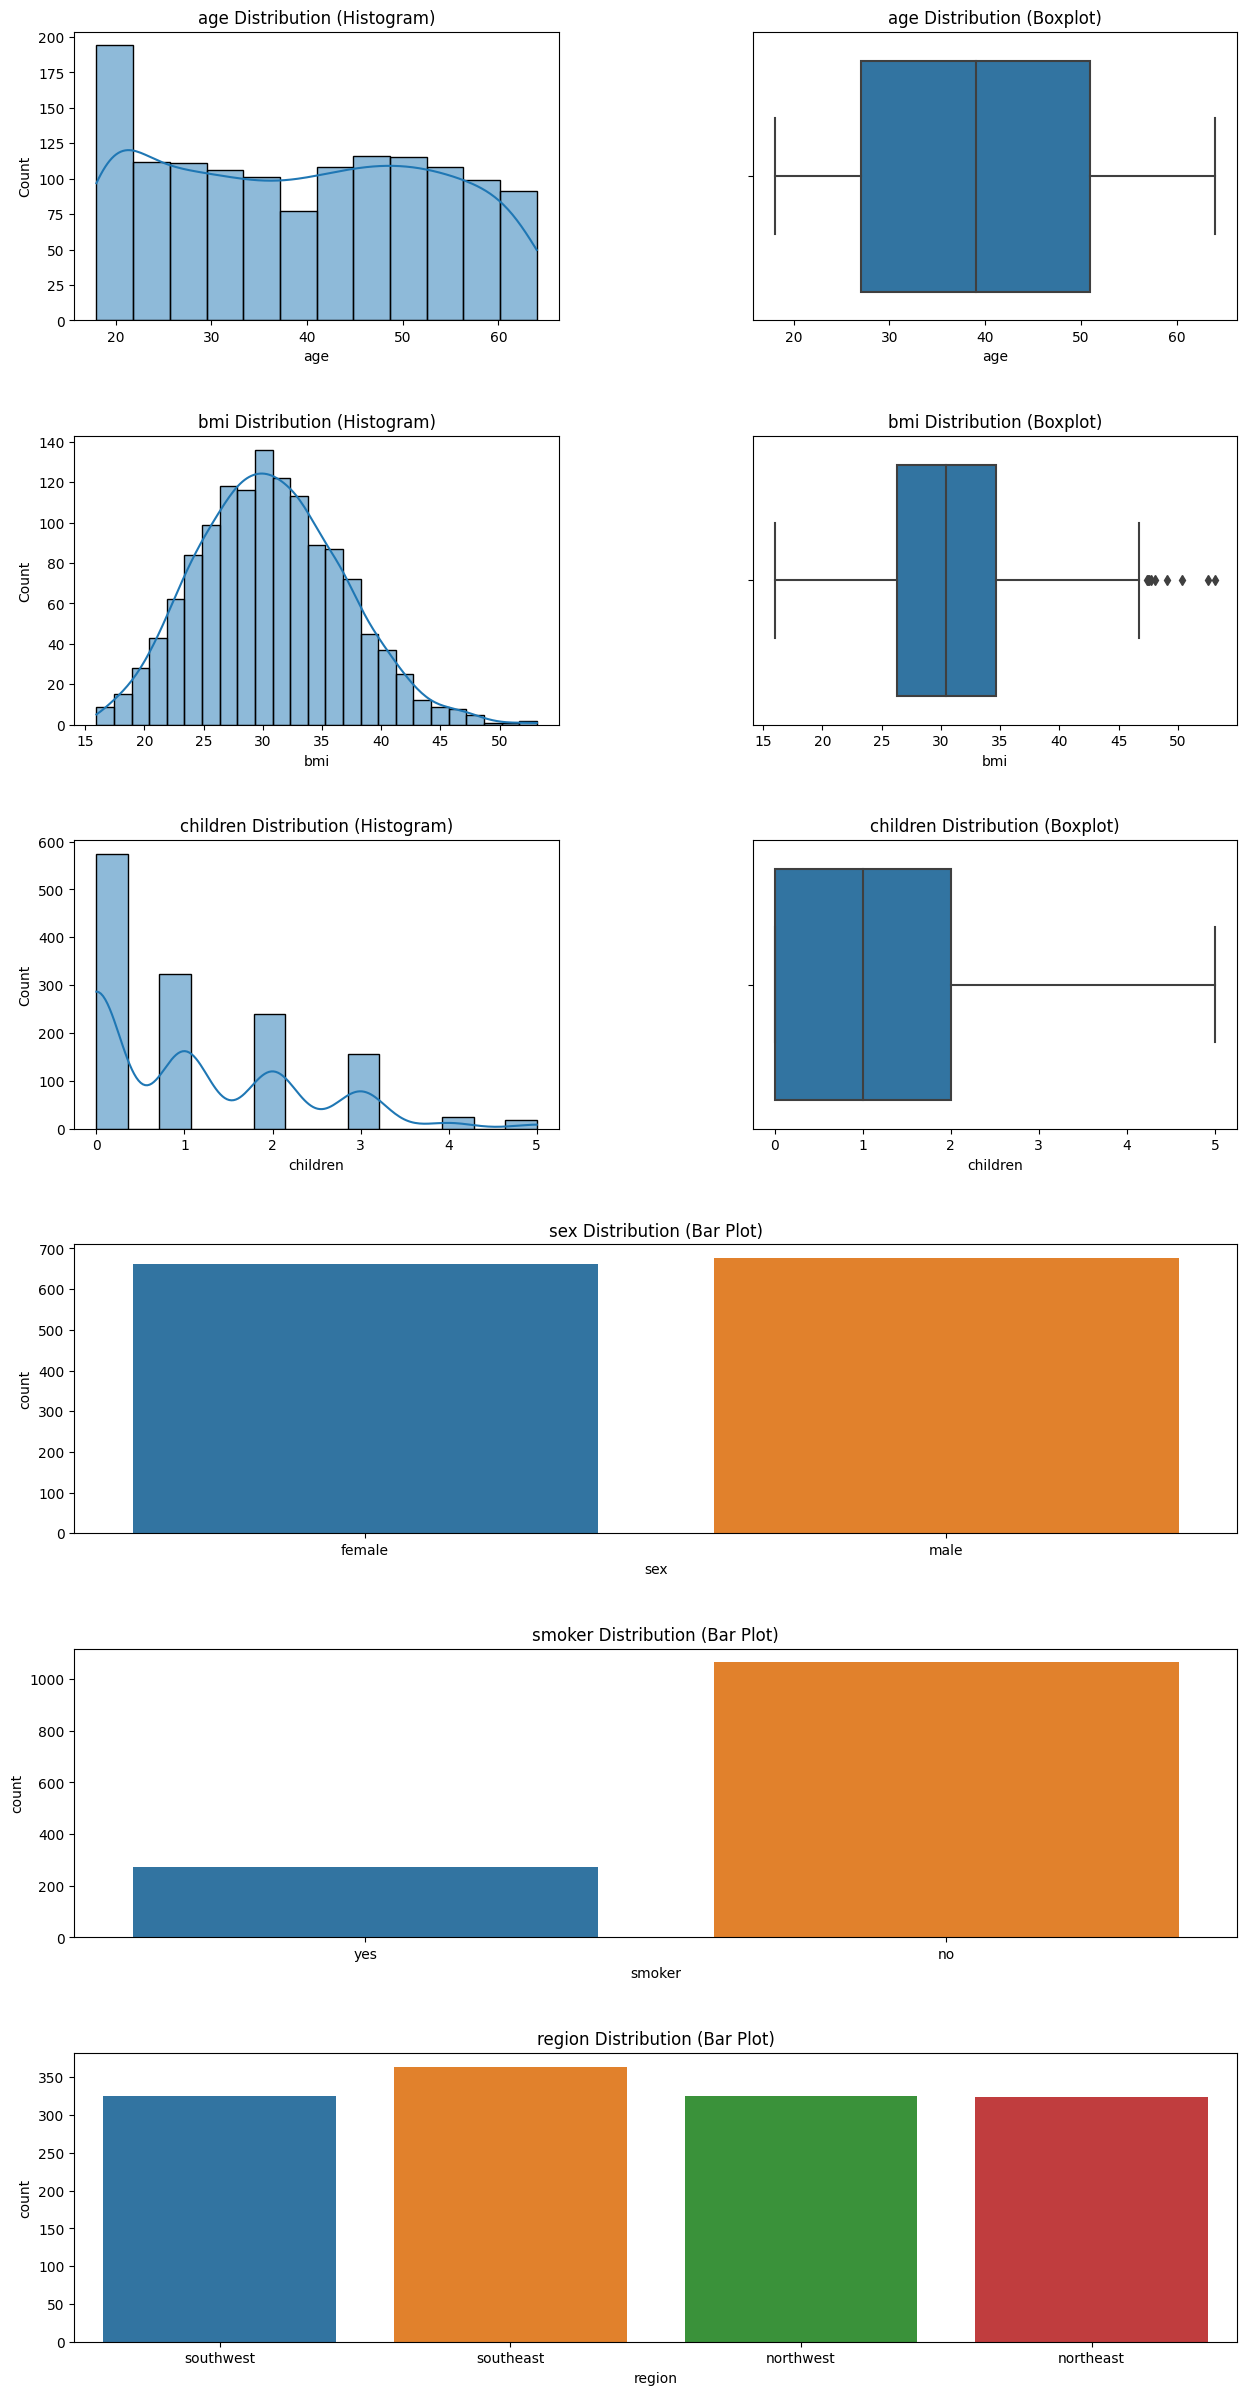

In [23]:
# Function to visualize distributions
def visualize_distributions(data):
    num_cols = data.select_dtypes(include=['number']).columns
    cat_cols = data.select_dtypes(include=['object', 'category']).columns
    total_plots = len(num_cols) + len(cat_cols)
    
    # Set up the figure size and grid
    fig = plt.figure(figsize=(15, total_plots*5))
    grid = plt.GridSpec(nrows=total_plots, ncols=2, figure=fig, wspace=0.4, hspace=0.4)
    
    plot_idx = 0
    for col in num_cols:
        # Histogram
        hist_ax = fig.add_subplot(grid[plot_idx, 0])
        sns.histplot(data=data, x=col, kde=True, ax=hist_ax)
        hist_ax.set_title(f'{col} Distribution (Histogram)')
        
        # Boxplot
        box_ax = fig.add_subplot(grid[plot_idx, 1])
        sns.boxplot(data=data, x=col, ax=box_ax)
        box_ax.set_title(f'{col} Distribution (Boxplot)')
        
        plot_idx += 1
        
    for col in cat_cols:
        # Bar plot
        bar_ax = fig.add_subplot(grid[plot_idx, 0:])
        sns.countplot(data=data, x=col, ax=bar_ax)
        bar_ax.set_title(f'{col} Distribution (Bar Plot)')
        
        plot_idx += 1
        
    plt.show()

# Call the function with your dataset
visualize_distributions(X)

age - Displays a roughly uniform distribution.

sex - Exhibits a nearly balanced proportion between categories.

bmi - Demonstrates an approximately normal distribution.

children - Skewed to the right, with a higher concentration in the lower range.

smoker - Noticeably greater number of observations in the no category compared 
to the yes category.

region - Presents a fairly even distribution across all categories.

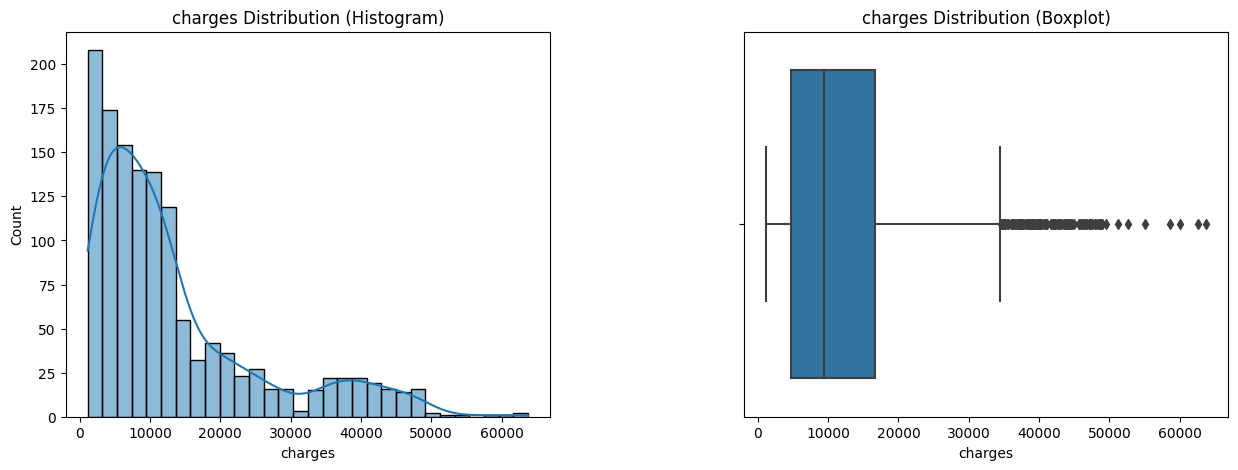

In [26]:
# Since our target variable is a Series, we need to convert it to a DataFrame in order to visualize its distribution
visualize_distributions(pd.DataFrame(y))


So as we can see the distribution is skewed to the right ( low volume in higher range and high volume in lower range)

# Univariate Analysis with Respect to the Target

In [27]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_univariate_numeric(X, y):
    fig = make_subplots(rows=X.shape[1], cols=1)
    for i, col in enumerate(X.columns):
        fig.add_trace(
            go.Scatter(
                x=X[col],
                y=y,
                name=col,
                mode='markers'
            ),
            row=i+1,
            col=1
        )
        fig.update_xaxes(
            title_text=col,
            row=i+1,
            col=1
        )
        fig.update_yaxes(
            title_text='charges',
            row=i+1,
            col=1
        )
    fig.update_layout(
        height=1200
    )
    fig.show()

In [28]:
plot_univariate_numeric(
    X.select_dtypes(include=np.number), 
    y
)

age - With increasing age, charges tend to rise as well (although there is significant variability in charges for any given age).

bmi - There is no evident relationship; however, a cluster of individuals with bmi > 30 and charges > 30k seems to be present. This group may become more visible when we conduct our bivariate analysis later.

children - There is no apparent relationship (although charges appear to decrease as the number of children increases). Since this feature has only six unique values, we can consider treating it as a categorical variable for univariate analysis purposes.

In [29]:
def plot_univariate_categorical(X, y):
    fig = make_subplots(rows=X.shape[1], cols=1)
    for i, col in enumerate(X.columns):
        fig.add_trace(
            go.Box(
                x=X[col],
                y=y,
                name=col,
            ),
            row=i+1,
            col=1
        )
        fig.update_xaxes(
            title_text=col,
            row=i+1,
            col=1
        )
        fig.update_yaxes(
            title_text='charges',
            row=i+1,
            col=1
        )
    fig.update_layout(height=1200)
    fig.show()

In [30]:
plot_univariate_categorical(
    X[['sex', 'smoker', 'region', 'children']], 
    y
)

sex - There are no notable differences in charges between the categories.

smoker - Charges for individuals with smoker == 'yes' are generally much higher than those with smoker == 'no'.

region - No substantial differences in charges are observed among the categories.

children - No significant differences in charges exist between the categories (although charges for children >= 4 lean towards lower amounts, this is likely attributable to the low volume in those categories, as seen in the Distributions section).